In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dask import delayed

In [2]:
def C_and_Cdot(S,dt):
    N = S.shape[0]
    C = np.dot(S, S.T)/S.shape[1]
    C_dot = np.dot(S[:,1:], S[:,:-1].T)/(S.shape[1]-1)
    C_dot -= C
    C_dot /= dt
        
    return C,C_dot      

def grad_L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #grad wrt h
    H = (h + np.dot(J,S).T).T
    G_1 = np.mean(S-np.tanh(H),axis=1)
    
    #grad wrt J
    G_0 = C_dot/gamma + C
    G_0 -= (np.dot(np.tanh(H),S.T))/N_t
    
    #new
    np.fill_diagonal(G_0,0)
    return np.concatenate((G_0.flatten(),G_1))
    
def parralel_grad(p,S_split,C,C_dot,gamma):
    ris = []
    for S in S_split:
        ris.append(delayed(grad_L)(p,S,C,C_dot,gamma))
    grad = delayed(sum)(ris).compute()/len(S_split)
    return grad

In [3]:
!ls DATA

spins_N100_steps100000_dt0.1_gamma1.npy
spins_N100_steps200000_dt0.1_gamma1.npy


In [4]:
S = np.load('DATA/spins_N100_steps200000_dt0.1_gamma1.npy')
#-----------------------params------------------------------------#
gamma = 1
dt = 0.1
N, steps = S.shape

C,C_dot = C_and_Cdot(S,dt)
np.random.seed(201098)
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)
p_real = np.concatenate((J.flatten(),h))
del J,h
#-----------------------n cores------------------------------------#
n_cores = 4

S_split = np.array_split(S,n_cores,axis = 1)
del S

In [5]:
%time _ = parralel_grad(p_real,S_split,C,C_dot,gamma)
%time _ = grad_L(p_real,np.hstack(S_split),C,C_dot,gamma)

CPU times: user 2.92 s, sys: 598 ms, total: 3.51 s
Wall time: 911 ms
CPU times: user 1.94 s, sys: 471 ms, total: 2.41 s
Wall time: 1.54 s


### Optimization

### SGA with momentum

100%|██████████| 500/500 [07:50<00:00,  1.06it/s]

MSE:  2857.3787992355756


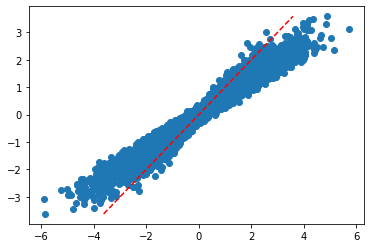

In [12]:
np.random.seed(1234)
p_mom = np.random.normal(0,2,N*N+N)
v = np.zeros(N*N+N)
### PARAMS
steps = 500
l_r = 0.1
fric = 0.9

for i in tqdm(range(steps)):
    g = parralel_grad(p_mom,S_split,C,C_dot,gamma)
    v = fric*v + l_r * g
    p_mom += v

print('MSE: ',np.sum((p_mom-p_real)**2))      
plt.figure()
plt.plot(p_mom,p_real,'o')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='red')

### RMS PROP

100%|██████████| 500/500 [07:59<00:00,  1.04it/s]

MSE:  16378.447504990841


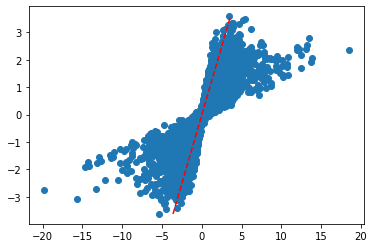

In [13]:
np.random.seed(1234)
p_rms = np.random.normal(0,2,N*N+N)
s = np.zeros(N*N+N)
### PARAMS
steps = 500
l_r = 0.05
beta = 0.9
eps = 10**(-8)


for i in tqdm(range(steps)):
    g = parralel_grad(p_rms,S_split,C,C_dot,gamma)
    s = beta * s + (1-beta)*g*g
    p_rms += l_r*g/np.sqrt(s+eps)                                      
    

print('MSE: ',np.sum((p_rms-p_real)**2))      
#plt.plot(ris)
plt.figure()
plt.plot(p_rms,p_real,'o')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='red')